In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import rubin_sim.phot_utils as photUtils

In [2]:
fdir = '../baseline'

In [3]:
# Read in the bandpasses.
lsst_hardware = {}
lsst_total = {}
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
components = ['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 'm1.dat', 'm2.dat', 'm3.dat']
# Change atmosphere here if desired. atmos_std.dat will give you X=1.2
atmosFile = 'atmos_10.dat'
for f in filterlist:
    # Read in just the hardware.
    lsst_hardware[f] = photUtils.Bandpass()
    comp = components + ['filter_' + f + '.dat']
    lsst_hardware[f].read_throughput_list(root_dir=fdir, component_list=comp)
    # Read in hardware plus atmosphere.
    lsst_total[f] = photUtils.Bandpass()
    comp = comp + [atmosFile]
    lsst_total[f].read_throughput_list(root_dir=fdir, component_list=comp)

In [4]:
atmos = photUtils.Bandpass()
atmos.read_throughput(os.path.join(fdir, atmosFile))

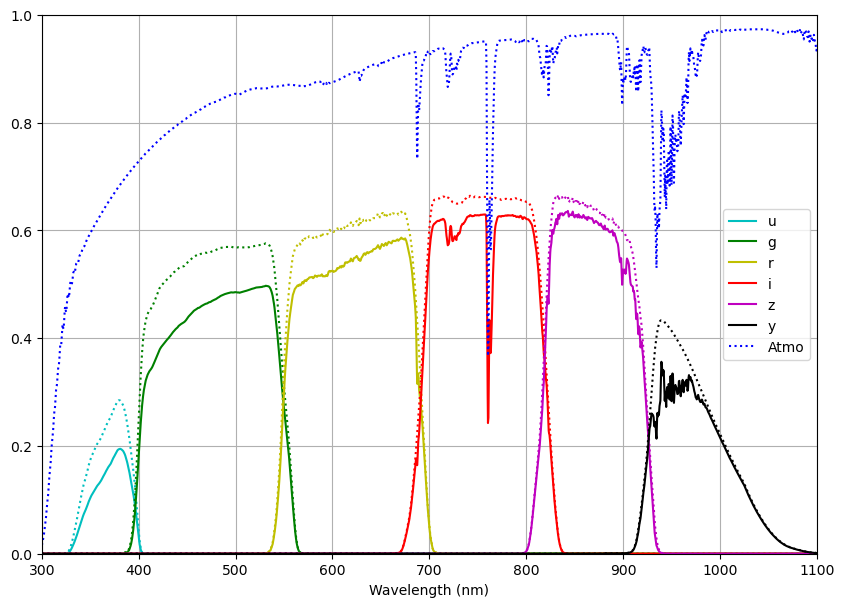

In [5]:
plt.figure(figsize=(10,7))
colors = {'u': 'c', 'g': 'g', 'r': 'y', 'i': 'r', 'z': 'm', 'y': 'k'}
for f in filterlist:
    plt.plot(lsst_hardware[f].wavelen, lsst_hardware[f].sb, color=colors[f], linestyle=':')
    plt.plot(lsst_total[f].wavelen, lsst_total[f].sb, color=colors[f], linestyle='-', label=f)
plt.plot(atmos.wavelen, atmos.sb, color='b', linestyle=':', label='Atmo')
plt.legend(numpoints=1, fancybox=True)
plt.xlabel('Wavelength (nm)')
plt.ylim(0, 1)
plt.xlim(300, 1100)
plt.grid(True)

In [6]:
# Set up a flat SED to use to calculate m5 values.
flatsed = photUtils.Sed()
flatsed.set_flat_sed()

In [7]:
# Read in the dark sky (this is a zenith dark sky SED)
darksky = photUtils.Sed()
darksky.read_sed_flambda(os.path.join(fdir, 'darksky.dat'))

In [8]:
# Calculate standard limiting magnitude .. setting effarea/readnoise explicitly as these match requirements
# (waiting for PR into photUtils defaults)
effarea = np.pi * (6.423/2.*100.)**2
readnoise = 8.8 # electrons / exposure
nexp = 2 
photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=2, gain=1.0,
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
instrNoiseSq = photUtils.calc_instr_noise_sq(photParams)
print('Instrumental Noise per visit (electrons)', np.sqrt(instrNoiseSq))
photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=1, gain=1.0,
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
instrNoiseSq = photUtils.calc_instr_noise_sq(photParams)
print('Instrumental Noise per 15s exposure (electrons)', np.sqrt(instrNoiseSq))
lsstDefaults = photUtils.LSSTdefaults()

Instrumental Noise per visit (electrons) 12.683847996566342
Instrumental Noise per 15s exposure (electrons) 8.968834929911466


In [9]:
# Save this, and write it out.
lsst_single = {}
nexp = 2.0
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    fwhm = lsstDefaults.fwhm_eff(f)
    photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, effarea=effarea, 
                                                 readnoise=readnoise, othernoise=0, darkcurrent=0.2)
    lsst_single[f] = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
print(lsst_single)

{'u': 23.4480975572855, 'g': 24.902278631339005, 'r': 24.478469134587233, 'i': 24.103165150240077, 'z': 23.540041474838404, 'y': 22.536909637970183}


In [10]:
lsstDefaults = photUtils.LSSTdefaults()
d = pd.DataFrame(index=filterlist, columns=['FWHMeff', 'skybackground', 'm5'])
for i, f in enumerate(filterlist):
    fwhm = lsstDefaults.fwhm_eff(f)
    skybackground = darksky.calc_mag(lsst_total[f])
    m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [fwhm, skybackground, m5]
print('For %d exposures (%.1f visits)' % (nexp, nexp/2))
d

For 2 exposures (1.0 visits)


,FWHMeff,skybackground,m5
u,0.92,23.048689,23.448098
g,0.87,22.241846,24.902279
r,0.83,21.196156,24.478469
i,0.8,20.454747,24.103165
z,0.78,19.610103,23.540041
y,0.76,18.581382,22.53691


In [11]:
# Calculate limiting magnitude for X exposures
nexp = 100
exptime = 15.0
photParams = photUtils.PhotometricParameters(exptime=exptime, nexp=nexp, 
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
lsstDefaults = photUtils.LSSTdefaults()
d = pd.DataFrame(index=filterlist, columns=['FWHMeff', 'skybackground', 'm5'])
for i, f in enumerate(filterlist):
    fwhm = lsstDefaults.fwhm_eff(f)
    skybackground = darksky.calc_mag(lsst_total[f])
    m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [fwhm, skybackground, m5]
print('For %d exposures (%.1f visits)' % (nexp, nexp/2))
d

For 100 exposures (50.0 visits)


,FWHMeff,skybackground,m5
u,0.92,23.048689,25.595672
g,0.87,22.241846,27.040391
r,0.83,21.196156,26.61328
i,0.8,20.454747,26.236199
z,0.78,19.610103,25.671675
y,0.76,18.581382,24.668262


In [12]:
# Calculate nexp needed to reach X limiting mag. (set m5goal) -- TEST with the same values as above. Expect 100 exp.
m5goal = {'u': 25.562, 'g': 26.907, 'r': 26.478, 'i': 26.029, 'z': 25.463, 'y': 24.556}

# yeah .. this is terribly brute-force. But it's fast enough.
d = pd.DataFrame(index=m5goal.keys(), columns=['m5_goal', 'FWHM_eff', 'skybackground', 'nexp', 'nvisits', 'm5'])
lsstDefaults = photUtils.LSSTdefaults()
for i, f in enumerate(m5goal):
    fwhm = lsstDefaults.fwhm_eff(f)
    nexp = 1
    photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                 effarea=effarea, readnoise=readnoise, 
                                                 othernoise=0, darkcurrent=0.2)
    m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    while m5 < m5goal[f]:
        nexp += 1
        # calculating the sky background here is not necessary, but gives a nice table entry.
        skybackground = darksky.calc_mag(lsst_total[f])
        photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                     effarea=effarea, readnoise=readnoise, 
                                                     othernoise=0, darkcurrent=0.2)
        m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [m5goal[f], fwhm, skybackground, nexp, nexp/2., m5]
print('Number of dark sky, zenith observations needed to reach given limiting magnitude')
d

Number of dark sky, zenith observations needed to reach given limiting magnitude


,m5_goal,FWHM_eff,skybackground,nexp,nvisits,m5
u,25.562,0.92,23.048689,95,47.5,25.567725
g,26.907,0.87,22.241846,79,39.5,26.91213
r,26.478,0.83,21.196156,78,39.0,26.478157
i,26.029,0.8,20.454747,69,34.5,26.034449
z,25.463,0.78,19.610103,69,34.5,25.469971
y,24.556,0.76,18.581382,82,41.0,24.560398


In [13]:
# Calculate nexp needed to reach X limiting mag. (set any m5goal)
m5goal = {'u': 25.4, 'g': 25.8, 'r': 25.5, 'i': 26, 'z': 26, 'y': 26}

# yeah .. this is terribly brute-force. But it's fast enough.
d = pd.DataFrame(index=m5goal.keys(), columns=['m5_goal', 'FWHMeff', 'skybackground', 'nexp', 'nvisits', 'm5'])
lsstDefaults = photUtils.LSSTdefaults()
for i, f in enumerate(m5goal):
    fwhm = lsstDefaults.fwhm_eff(f)
    nexp = 1
    photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                 effarea=effarea, readnoise=readnoise, 
                                                 othernoise=0, darkcurrent=0.2)
    m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    while m5 < m5goal[f]:
        nexp += 1
        skybackground = darksky.calc_mag(lsst_total[f])
        photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, 
                                                     effarea=effarea, readnoise=readnoise, 
                                                     othernoise=0, darkcurrent=0.2)
        m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [m5goal[f], fwhm, skybackground, nexp, nexp/2., m5]
print('Number of dark sky, zenith observations needed to reach given limiting magnitude')
d

Number of dark sky, zenith observations needed to reach given limiting magnitude


,m5_goal,FWHMeff,skybackground,nexp,nvisits,m5
u,25.4,0.92,23.048689,70,35.0,25.401287
g,25.8,0.87,22.241846,11,5.5,25.837378
r,25.5,0.83,21.196156,13,6.5,25.502481
i,26,0.8,20.454747,65,32.5,26.001974
z,26,0.78,19.610103,183,91.5,26.000077
y,26,0.76,18.581382,1161,580.5,26.000187


Text(0.5, 1.0, 'Limiting magnitude for a series of dark sky, zenith, 15s LSST observations')

<Figure size 1000x800 with 0 Axes>

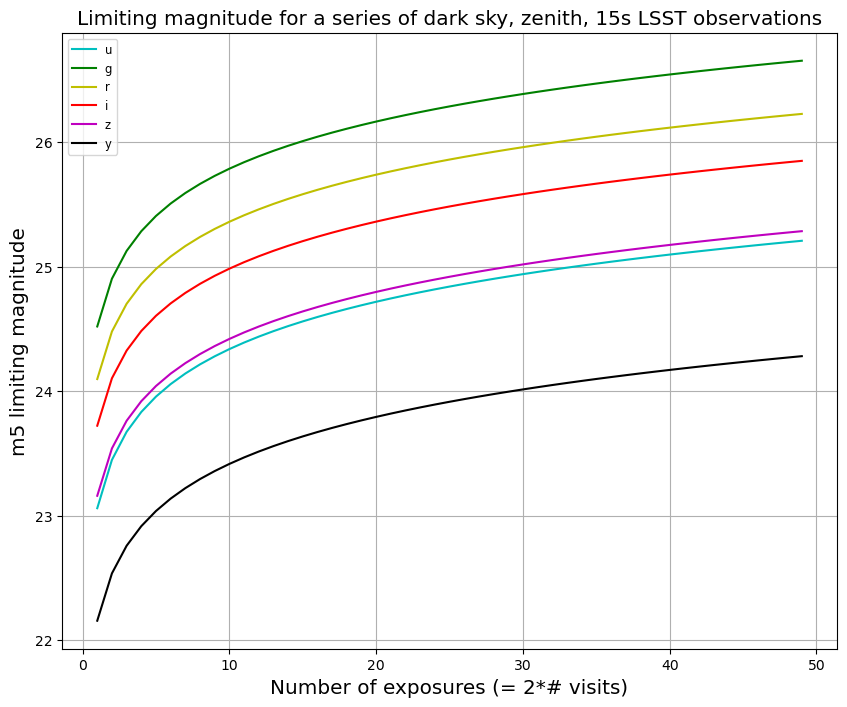

In [14]:
# Okay let's make this easy to look up in the future perhaps. 
# With these conditions: readnoise, darkcurrent, dark sky, zenith, FWHMeff as above:
plt.figure(figsize=(10, 8))
nexps = np.arange(1, 50, 1)
m5 = np.zeros(len(nexps), float)
plt.figure(figsize=(10, 8))
for f in filterlist:
    fwhm = lsstDefaults.fwhm_eff(f)
    for i, nexp in enumerate(nexps):
        photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, effarea=effarea,
                                                    readnoise=readnoise, othernoise=0, darkcurrent=0.2)
        m5[i] = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    plt.plot(nexps, m5, color=colors[f], linestyle='-', label=f)
plt.grid(True)
plt.legend(fancybox=True, numpoints=1, fontsize='small')
plt.xlabel(r'Number of exposures (= 2*# visits)', fontsize='x-large')
plt.ylabel(r'm5 limiting magnitude', fontsize='x-large')
plt.title(r'Limiting magnitude for a series of dark sky, zenith, 15s LSST observations', fontsize='x-large')

Text(0.5, 1.0, 'Limiting magnitude for a series of dark sky, zenith, 15s LSST observations')

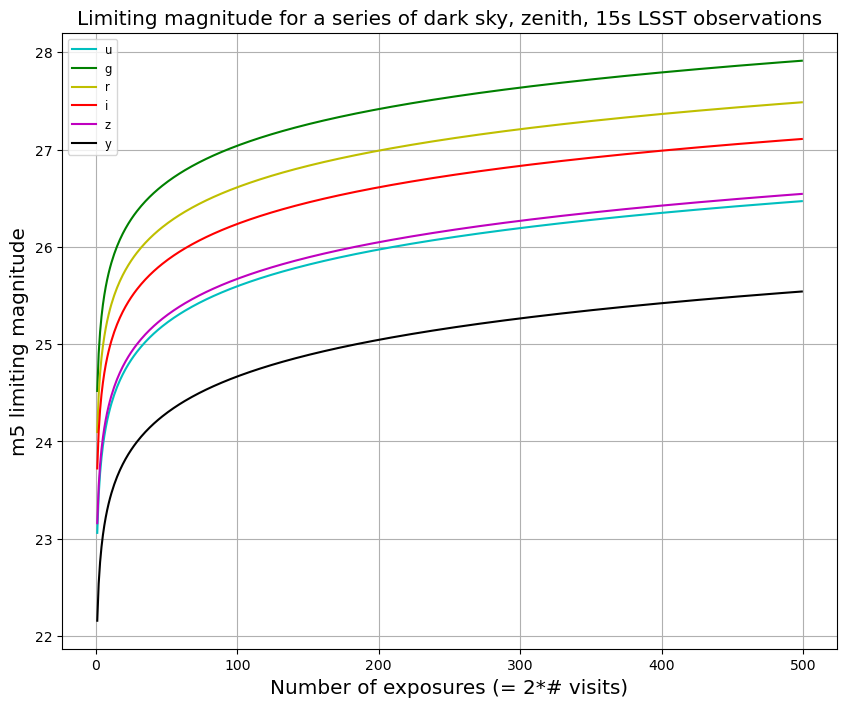

In [15]:
# Extend to larger numbers of visits.
plt.figure(figsize=(10, 8))
nexps = np.arange(1, 500, 1)
m5 = np.zeros(len(nexps), float)
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    fwhm = lsstDefaults.fwhm_eff(f)
    for i, nexp in enumerate(nexps):
        photParams = photUtils.PhotometricParameters(exptime=15.0, nexp=nexp, effarea=effarea,
                                                    readnoise=readnoise, othernoise=0, darkcurrent=0.2)
        m5[i] = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    plt.plot(nexps, m5, color=colors[f], linestyle='-', label=f)
plt.grid(True)
plt.legend(fancybox=True, numpoints=1, fontsize='small')
plt.xlabel(r'Number of exposures (= 2*# visits)', fontsize='x-large')
plt.ylabel(r'm5 limiting magnitude', fontsize='x-large')
plt.title(r'Limiting magnitude for a series of dark sky, zenith, 15s LSST observations', fontsize='x-large')

In [16]:
# And super simple scaling relationship. nvisits ~ (10^((m_req - m_single)/2.5)**2)
# Please make sure you have the correct m5 depths 

m5_req = {'u': 25.4, 'g': 25.6, 'r': 25.3, 'i': 25.3, 'z': 24.9} # 'y': 24.9}
overview_m5 = {'u': 23.7, 'g': 24.9, 'r': 24.4, 'i': 24.0, 'z': 23.5 }
srd_m5 = {'u': 23.9, 'g':25.0, 'r': 24.7, 'i': 24.0, 'z': 23.3, 'y': 22.1}

#m5_ref = overview_m5
m5_ref = lsst_single

d = pd.DataFrame(index=m5_req.keys(), columns=['Desired m5', 'LSST single visit', 
                                               'Nvisits_req'])
for i, f in enumerate(m5_req):
    nvisits_req = int(np.ceil(np.power(10, (m5_req[f] - m5_ref[f])/2.5)**2))
    d.iloc[i] = [m5_req[f],  m5_ref[f], nvisits_req]
display(d)
print('** Please note that the single visit depths for LSST are evolving as we get closer to actual hardware.')
print('** The values calculated here^ are up to date with expected performance, as of the commit date of this notebook.')
print('     ^(if using lsst_single as the m5_ref value; overview_m5 values are only consistent with the overview paper).')

,Desired m5,LSST single visit,Nvisits_req
u,25.4,23.448098,37
g,25.6,24.902279,4
r,25.3,24.478469,5
i,25.3,24.103165,10
z,24.9,23.540041,13


** Please note that the single visit depths for LSST are evolving as we get closer to actual hardware.
** The values calculated here^ are up to date with expected performance, as of the commit date of this notebook.
     ^(if using lsst_single as the m5_ref value; overview_m5 values are only consistent with the overview paper).


In [17]:
# Using illustrative number of visits laid out in SRD:
nvisits = {'u': 56, 'g': 80, 'r': 184, 'i': 184, 'z': 160, 'y': 160}
d = pd.DataFrame(index=filterlist, columns=['Nvisits', 'M5_single', 'M5_coadd'])
for i, f in enumerate(filterlist):
    nexp = nvisits[f] * 2.0
    exptime = 15.0
    photParams2 = photUtils.PhotometricParameters(exptime=exptime, nexp=2, 
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
    photParams = photUtils.PhotometricParameters(exptime=exptime, nexp=nexp, 
                                             effarea=effarea, readnoise=readnoise, 
                                             othernoise=0, darkcurrent=0.2)
    lsstDefaults = photUtils.LSSTdefaults()
    fwhm = lsstDefaults.fwhm_eff(f)
    skybackground = darksky.calc_mag(lsst_total[f])
    m5_single = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams2, fwhm_eff=fwhm)
    m5_coadd = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [nvisits[f], m5_single, m5_coadd]
d

,Nvisits,M5_single,M5_coadd
u,56,23.448098,25.657408
g,80,24.902279,27.296033
r,184,24.478469,27.321458
i,184,24.103165,26.94424
z,160,23.540041,26.303685
y,160,22.53691,25.300252


In [18]:
# Calculate nexp needed to reach X limiting mag. (set any m5goal) .. example for DD
m5goal = {'u': 28.3, 'g': 28.4, 'r': 28.5, 'i': 28.3, 'z': 28, 'y': 26.2}

# yeah .. this is terribly brute-force. But it's fast enough.
d = pd.DataFrame(index=m5goal.keys(), columns=['m5_goal', 'FWHMeff', 'skybackground', 'nexp', 'nvisits', 'm5'])
lsstDefaults = photUtils.LSSTdefaults()
for i, f in enumerate(m5goal):
    fwhm = lsstDefaults.fwhm_eff(f)
    nexp = 1
    photParams = photUtils.PhotometricParameters(exptime=30.0, nexp=nexp, 
                                                 effarea=effarea, readnoise=readnoise, 
                                                 othernoise=0, darkcurrent=0.2)
    m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    while m5 < m5goal[f]:
        nexp += 1
        skybackground = darksky.calc_mag(lsst_total[f])
        photParams = photUtils.PhotometricParameters(exptime=30.0, nexp=nexp, 
                                                     effarea=effarea, readnoise=readnoise, 
                                                     othernoise=0, darkcurrent=0.2)
        m5 = photUtils.calc_m5(darksky, lsst_total[f], lsst_hardware[f], photParams, fwhm_eff=fwhm)
    d.iloc[i] = [m5goal[f], fwhm, skybackground, nexp, nexp/1., m5]
print('Number of dark sky, zenith observations needed to reach given limiting magnitude')
d

Number of dark sky, zenith observations needed to reach given limiting magnitude


,m5_goal,FWHMeff,skybackground,nexp,nvisits,m5
u,28.3,0.92,23.048689,4521,4521.0,28.300019
g,28.4,0.87,22.241846,535,535.0,28.400573
r,28.5,0.83,21.196156,1503,1503.0,28.5001
i,28.3,0.8,20.454747,2135,2135.0,28.300104
z,28,0.78,19.610103,3527,3527.0,28.00015
y,26.2,0.76,18.581382,817,817.0,26.200572
